Replace imageJ for analysis of Tiff from gafchromic film scan

lOAD TIFF http://scikit-image.org/docs/dev/api/skimage.external.tifffile.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, filters, feature, measure
from pylinac.core.image import Image 
from pylinac.core.profile import SingleProfile 
% matplotlib inline

In [2]:
tiff_file = '170313-REDA-10MV-10x10-125FSD.tif'
im = io.imread(tiff_file)
im.shape  # 3 layers are RGB

(1123, 816, 3)

In [3]:
im = io.imread(tiff_file)

### Show the 3 channels using matplotlib

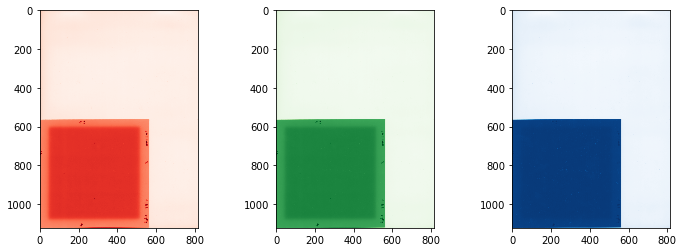

In [4]:
fig_width = 12
fig_height = 4

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(fig_width, fig_height))

ax1.imshow(im[:,:,0], cmap='Reds_r')  
ax2.imshow(im[:,:,1], cmap='Greens_r')  
ax3.imshow(im[:,:,2], cmap='Blues_r') ; 

### Some skimage processing to find ROI etc

Image contants for regions.

1. Background
2. Un-irradiated film
3. Irradiated film
4. Text

49301.5778279


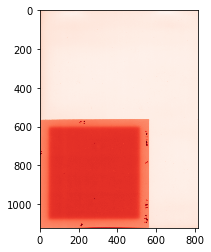

In [5]:
img1 = im[:,:,0]
print(img1.mean())
plt.imshow(img1, cmap='Reds_r')

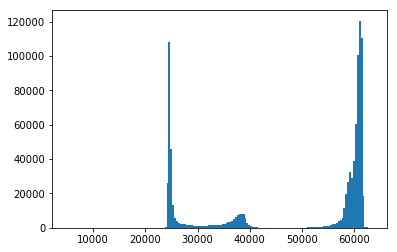

In [6]:
plt.hist(img1.flatten() , bins = 160);   # determine interesting pixels

See three peaks, try KMeans clustering to determine regions of image http://opencvpython.blogspot.co.uk/2012/12/k-means-clustering-2-working-with-scipy.html

In [7]:
from scipy.cluster import vq

peaks_to_find = 3
peaks, dist = vq.kmeans(img1.flatten().astype(float), peaks_to_find)
peaks.sort()
peaks

array([ 25041.53911583,  37018.9867119 ,  60249.26397135])

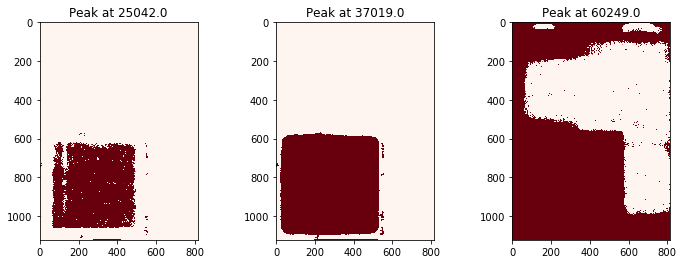

In [8]:
fig_width = 12
fig_height = 4
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(fig_width, fig_height))

peak_width = 5  # range around peak to show
ax1.imshow(img1, vmin=peaks[0]-peak_width, vmax=peaks[0]+peak_width, cmap='Reds_r')
ax1.set_title('Peak at %s' % str(round(peaks[0])))  

ax2.imshow(img1, vmin=peaks[1]-peak_width, vmax=peaks[1]+peak_width, cmap='Reds_r') 
ax2.set_title('Peak at %s' % str(round(peaks[1]))) 

ax3.imshow(img1, vmin=peaks[2]-peak_width, vmax=peaks[2]+peak_width, cmap='Reds_r') 
ax3.set_title('Peak at %s' % str(round(peaks[2])))  ;

###  Basic thresholding using the identified peaks

Want the data under the second peak

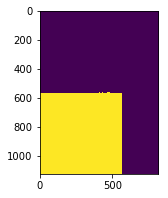

In [9]:
img1_thresholded_bool = img1 < peaks[1]*1.1    # get data below 110% of second peak 

fig_width = 3

f, ax1 = plt.subplots(1,1, figsize=(fig_width*3, fig_width))
ax1.imshow(img1_thresholded_bool)

### Otsu method to find ROI

44310


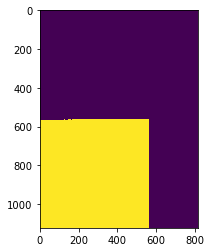

In [10]:
thresh = filters.threshold_otsu(img1)
print(thresh)
binary = img1 <= thresh
plt.imshow(binary);

Get the lenght of the sides

In [11]:
perimeter_side = int(measure.perimeter(binary)/4)   # get the length of the sides of the binary object
perimeter_side

568

Now get only the scan data

In [12]:
img_data = im[perimeter_side:,:im.shape[0] - perimeter_side,0]
img2 = Image.load(img_data) # manually crop the image and keep only the red channel

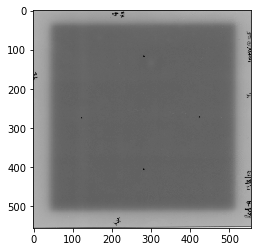

In [13]:
img2.plot();

C:\Users\RCole02\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


The FWHM is 479 centered on 272


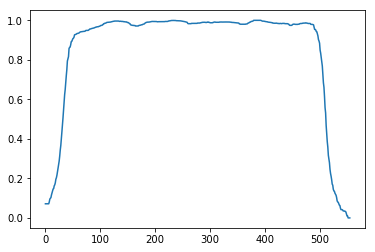

In [14]:
mid_point =int(img2.shape[0]/2)
row1 = img2[:, mid_point]    # get the orthogonal riws

profile1 = SingleProfile(row1)  # plot a row
profile1.invert()
profile1.filter(size=0.05, kind='median')
profile1.ground()
profile1.normalize()
plt.plot(profile1)

print('The FWHM is %d centered on %d' % (profile1.fwxm(x=50), profile1.fwxm_center(x=50)))

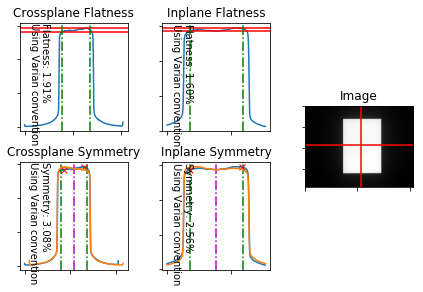

In [15]:
from pylinac.flatsym import BeamImage

my_img = BeamImage()
my_img.run_demo()